DISCRIMINANT ANALYSIS & ORDINAL VARIABLES ANALYSIS

1. Libraries and data importation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    cohen_kappa_score, mean_absolute_error
)
from itertools import combinations
import tqdm
exec(open('functions sy09/utils.py').read())
exec(open('functions sy09/utils_tp05.py').read())
exec(open('functions sy09/utils_tp06.py').read())
exec(open('functions sy09/utils_tp07.py').read())

In [2]:
data_new_grade_class = pd.read_csv('data/Student_performance_data_new_GradeClass.csv')

In [3]:
df = data_new_grade_class
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   int64  
 15  totalActivities    2392 non-null   int64  
dtypes: float64(2), int64(14)

2. Initial prediction with all variables and dimension reduction by PCA

A. With 5 classes to predict: A/B/C/D/F

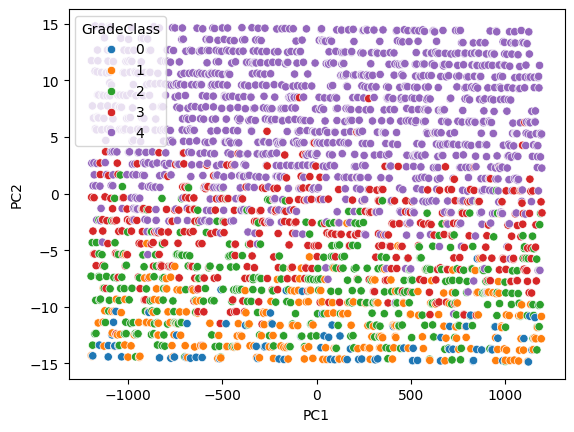

c:\Users\romal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\romal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\romal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\romal\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\U

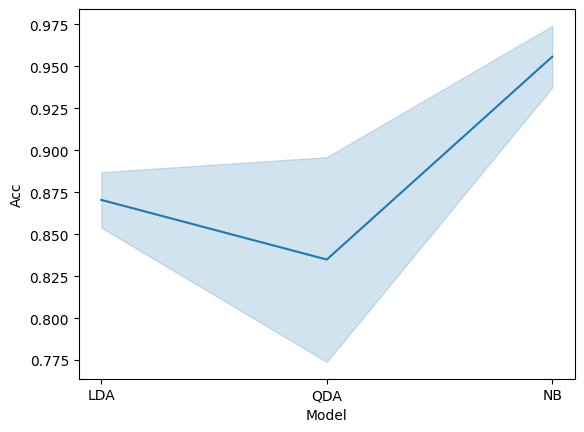

In [4]:
models = [
    (LinearDiscriminantAnalysis, "LDA"),
    (QuadraticDiscriminantAnalysis, "QDA"),
    (GaussianNB, "NB"),
]
def validation_errors(df, models):
    y = df.GradeClass
    X = df.drop(columns=["GradeClass"])
    for model, name in models:
        for acc in cross_val_score(model(), X, y, cv=10):
            yield name, acc

def add_decision_boundaries(df, models):
    colors = sns.color_palette()
    for model, name in models:
        y = df.GradeClass
        X = df.drop(columns=["GradeClass"])
        cls = model()
        cls.fit(X, y)
        add_decision_boundary(cls, label=name, color=colors.pop(), region=False)

df = data_new_grade_class
scatterplot_pca(data=df, hue="GradeClass")
#add_decision_boundaries(df, models)
plt.show()

df = pd.DataFrame(validation_errors(df, models), columns=["Model", "Acc"])

sns.lineplot(x="Model", y="Acc", data=df, errorbar="sd")
plt.show()


Results: we applied the models on our data transformed by pca to try to have the decision frontier visible. It was successful but not the same analysis: we lose precision.

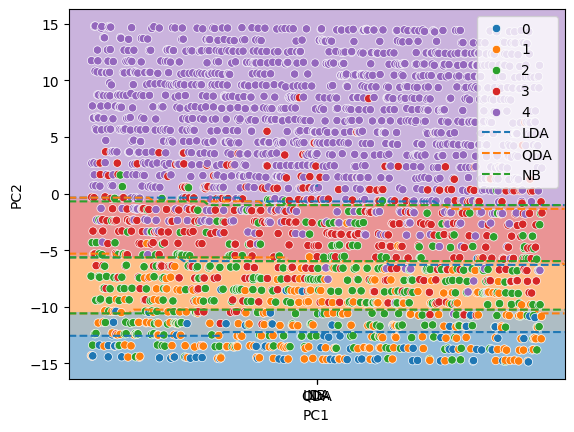

In [ ]:
def get_pca_features(df, n_components=2):
    y = df.GradeClass
    X = df.drop(columns=["GradeClass"])
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)]), y

def validation_errors_pca(df, models):
    X_pca, y = get_pca_features(df)
    for model, name in models:
        for acc in cross_val_score(model(), X_pca, y, cv=10):
            yield name, acc

def add_decision_boundaries_pca(df, models):
    X_pca, y = get_pca_features(df)
    colors = sns.color_palette("tab10", n_colors=len(models))
    for (model, name), color in zip(models, colors):
        cls = model()
        cls.fit(X_pca, y)
        add_decision_boundary(cls, label=name, color=color, region=True)

df = data_new_grade_class

# Plot PCA scatterplot
X_pca, y = get_pca_features(df)
df_pca = X_pca.copy()
df_pca["GradeClass"] = y.values
scatterplot_pca(data=df_pca, hue="GradeClass")


add_decision_boundaries_pca(df, models)
#plt.show()
#plt.savefig('ad_acp.pdf')

df_val = pd.DataFrame(validation_errors_pca(df, models), columns=["Model", "Acc"])
sns.lineplot(x="Model", y="Acc", data=df_val, errorbar="sd")
plt.show()

B. With 2 classes to predict: Pass/Fail

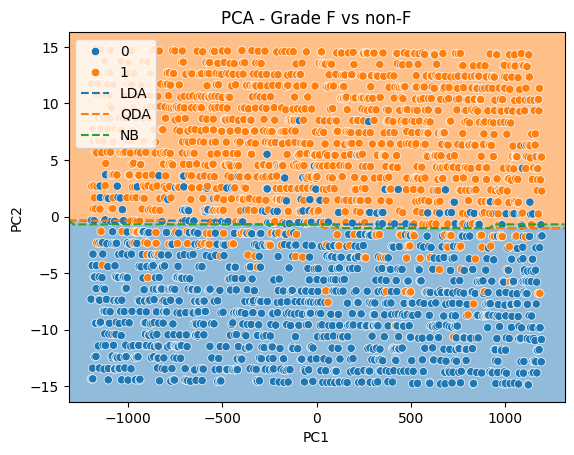

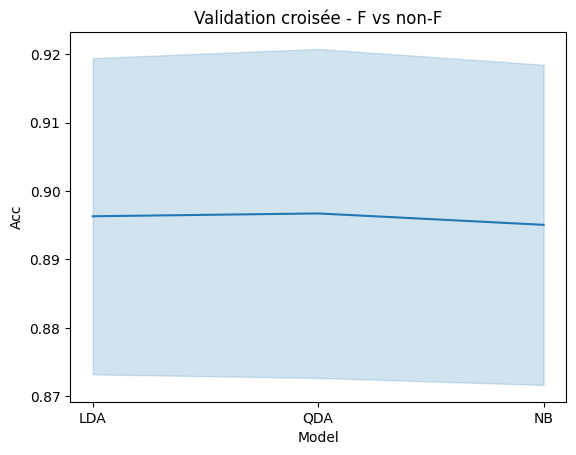

In [6]:
def get_pca_features_binary(df, n_components=2):
    df = df.copy()
    df["GradeBinary"] = df["GradeClass"].apply(lambda x: 1 if x == 4 else 0)
    y = df["GradeBinary"]
    X = df.drop(columns=["GradeClass", "GradeBinary"])
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)]), y

def validation_errors_pca_binary(df, models):
    X_pca, y = get_pca_features_binary(df)
    for model, name in models:
        for acc in cross_val_score(model(), X_pca, y, cv=10):
            yield name, acc

def add_decision_boundaries_pca_binary(df, models):
    X_pca, y = get_pca_features_binary(df)
    colors = sns.color_palette("tab10", n_colors=len(models))
    for (model, name), color in zip(models, colors):
        cls = model()
        cls.fit(X_pca, y)
        add_decision_boundary(cls, label=name, color=color, region=True)

# Scatterplot PCA pour binaire
X_pca_bin, y_bin = get_pca_features_binary(df)
df_pca_bin = X_pca_bin.copy()
df_pca_bin["GradeBinary"] = y_bin.values
scatterplot_pca(data=df_pca_bin, hue="GradeBinary")

add_decision_boundaries_pca_binary(df, models)
plt.title("PCA - Grade F vs non-F")
plt.show()

# Validation croisée
df_val_bin = pd.DataFrame(validation_errors_pca_binary(df, models), columns=["Model", "Acc"])
sns.lineplot(x="Model", y="Acc", data=df_val_bin, errorbar="sd")
plt.title("Validation croisée - F vs non-F")
plt.show()


C. With 3 class to predict: Bad/In the middle/Good results

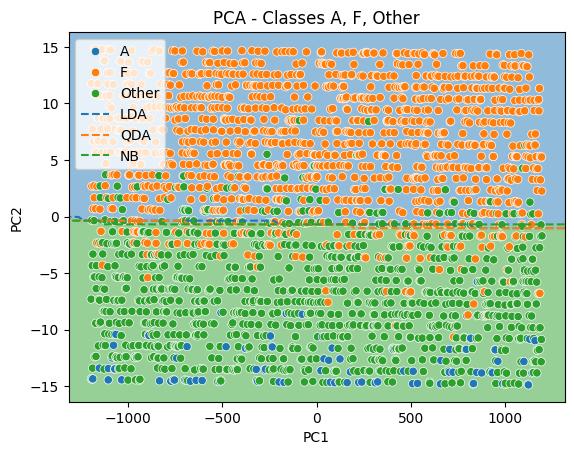

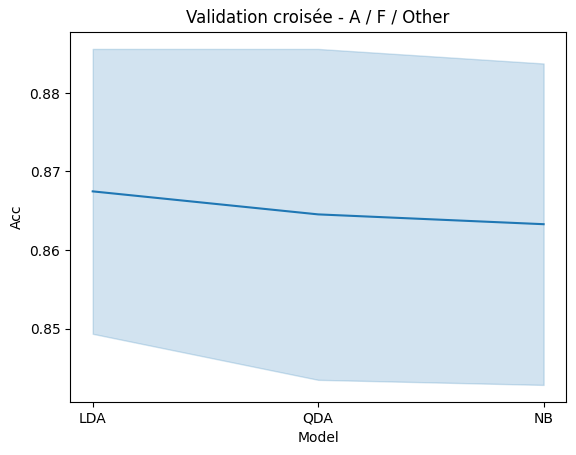

In [7]:
models = [
    (LinearDiscriminantAnalysis, "LDA"),
    (QuadraticDiscriminantAnalysis, "QDA"),
    (GaussianNB, "NB"),
]

def get_pca_features_3class(df, n_components=2):
    df = df.copy()
    df["Grade3Class"] = df["GradeClass"].apply(lambda x: 'F' if x == 4 else ('A' if x == 0 else 'Other'))
    y = df["Grade3Class"]
    X = df.drop(columns=["GradeClass", "Grade3Class"])
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)]), y

def validation_errors_pca_3class(df, models):
    X_pca, y = get_pca_features_3class(df)
    for model, name in models:
        for acc in cross_val_score(model(), X_pca, y, cv=10):
            yield name, acc

def add_decision_boundaries_pca_3class(df, models):
    X_pca, y = get_pca_features_3class(df)
    colors = sns.color_palette("tab10", n_colors=len(models))
    for (model, name), color in zip(models, colors):
        cls = model()
        cls.fit(X_pca, y)
        add_decision_boundary(cls, label=name, color=color, region=True)

# Scatterplot PCA pour 3 classes
X_pca_3, y_3 = get_pca_features_3class(df)
df_pca_3 = X_pca_3.copy()
df_pca_3["Grade3Class"] = y_3.values
scatterplot_pca(data=df_pca_3, hue="Grade3Class")

add_decision_boundaries_pca_3class(df, models)
plt.title("PCA - Classes A, F, Other")
plt.show()

# Validation croisée
df_val_3 = pd.DataFrame(validation_errors_pca_3class(df, models), columns=["Model", "Acc"])
sns.lineplot(x="Model", y="Acc", data=df_val_3, errorbar="sd")
plt.title("Validation croisée - A / F / Other")
plt.show()


3. Selection of relevant variables

A. With a focus on the variables : TotalActivities, Absences and StudyTimeWeekly

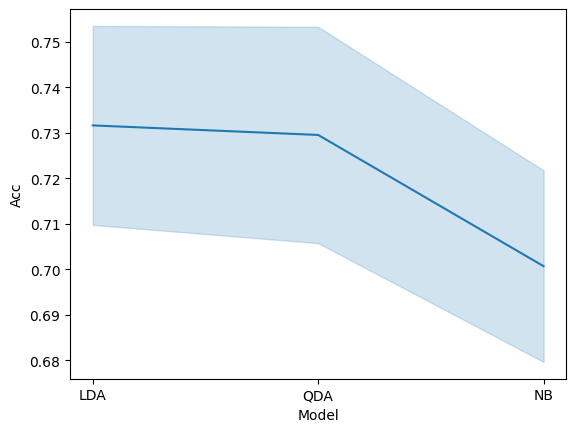

In [8]:
df = data_new_grade_class[['totalActivities', 'Absences', 'StudyTimeWeekly', 'GradeClass']]

models = [
    (LinearDiscriminantAnalysis, "LDA"),
    (QuadraticDiscriminantAnalysis, "QDA"),
    (GaussianNB, "NB"),
]

def validation_accuracies(df, models):
    y = df['GradeClass']
    X = df.drop(columns=['GradeClass'])
    for model, name in models:
        scores = cross_val_score(model(), X, y, cv=10)
        for score in scores:
            yield name, score


df_scores = pd.DataFrame(validation_accuracies(df, models), columns=["Model", "Accuracy"])


df_val = pd.DataFrame(validation_errors_pca(df, models), columns=["Model", "Acc"])
sns.lineplot(x="Model", y="Acc", data=df_val, errorbar="sd")
plt.show()

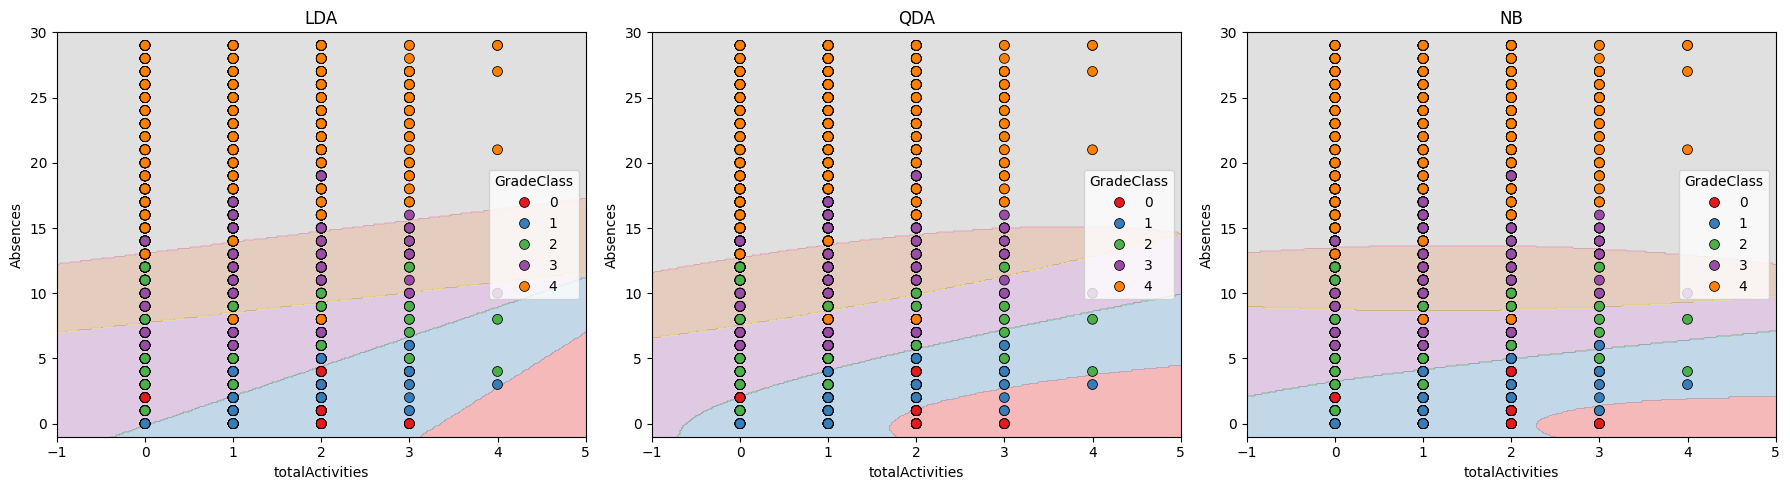

In [9]:
# Sélection des 2 variables pour la visualisation
features = ['totalActivities', 'Absences']
df = data_new_grade_class[features + ['GradeClass']]

X = df[features].values
y = df['GradeClass'].values
classes = np.unique(y)

models = [
    (LinearDiscriminantAnalysis(), "LDA"),
    (QuadraticDiscriminantAnalysis(), "QDA"),
    (GaussianNB(), "NB"),
]

# Fonction pour tracer la frontière de décision
def plot_decision_boundary(clf, X, y, ax, title):
    # Définir la grille
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    # Prédire sur la grille
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Tracer la région
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='Set1')
    # Tracer les points
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='Set1', ax=ax, edgecolor='k', s=50)
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_title(title)
    ax.legend(title='GradeClass')

# Tracer les modèles
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (model, name) in zip(axes, models):
    model.fit(X, y)
    plot_decision_boundary(model, X, y, ax, name)

plt.tight_layout()
plt.show()


  Model  mean_accuracy  std_accuracy
0   LDA       0.740793      0.016874
1    NB       0.706935      0.015895
2   QDA       0.745384      0.017609


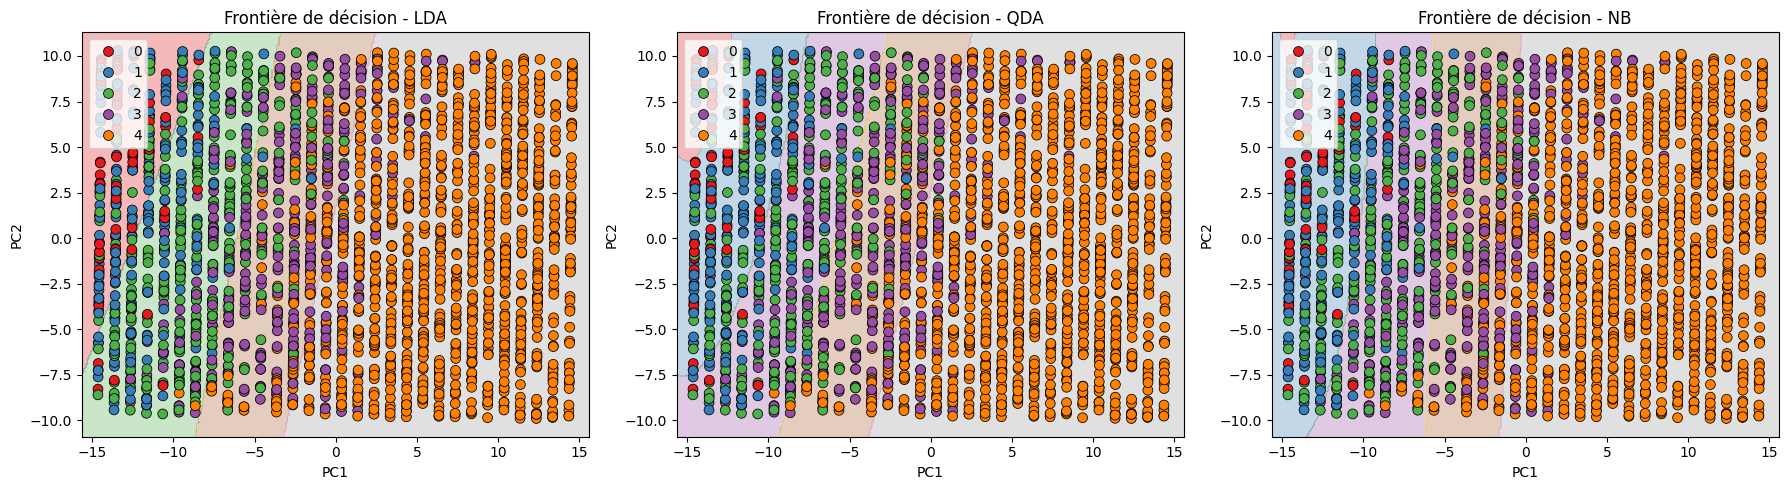

In [10]:
# 1. Sélection des données
df = data_new_grade_class[['totalActivities', 'Absences', 'StudyTimeWeekly', 'GradeClass']]

X = df.drop(columns=['GradeClass']).values
y = df['GradeClass'].values

# 2. PCA pour réduction à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# On refait un dataframe pour le plot
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['GradeClass'] = y

# 3. Définition des modèles
models = [
    (LinearDiscriminantAnalysis, "LDA"),
    (QuadraticDiscriminantAnalysis, "QDA"),
    (GaussianNB, "NB"),
]

# 4. Validation croisée (optionnel)
def validation_accuracies(X, y, models):
    for model, name in models:
        scores = cross_val_score(model(), X, y, cv=10)
        for score in scores:
            yield name, score

df_scores = pd.DataFrame(validation_accuracies(X, y, models), columns=["Model", "Accuracy"])
summary = df_scores.groupby("Model").agg(mean_accuracy=("Accuracy", "mean"),
                                        std_accuracy=("Accuracy", "std")).reset_index()
print(summary)

# 5. Fonction pour tracer la frontière de décision dans l’espace PCA
def plot_decision_boundary(clf, X, y, ax, title, cmap='Set1'):
    # Création d'une grille
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    # Prédictions sur la grille
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Contour
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    
    # Scatter plot des données
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='Set1', ax=ax, edgecolor='k', s=50)
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

# 6. On projette les données dans l’espace PCA, on entraîne les modèles sur ces 2 composantes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (model, name) in zip(axes, models):
    clf = model()
    clf.fit(X_pca, y)
    plot_decision_boundary(clf, X_pca, y, ax, f"Frontière de décision - {name}")

plt.tight_layout()
plt.show()


c:\Users\romal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\romal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\romal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\romal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\romal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  

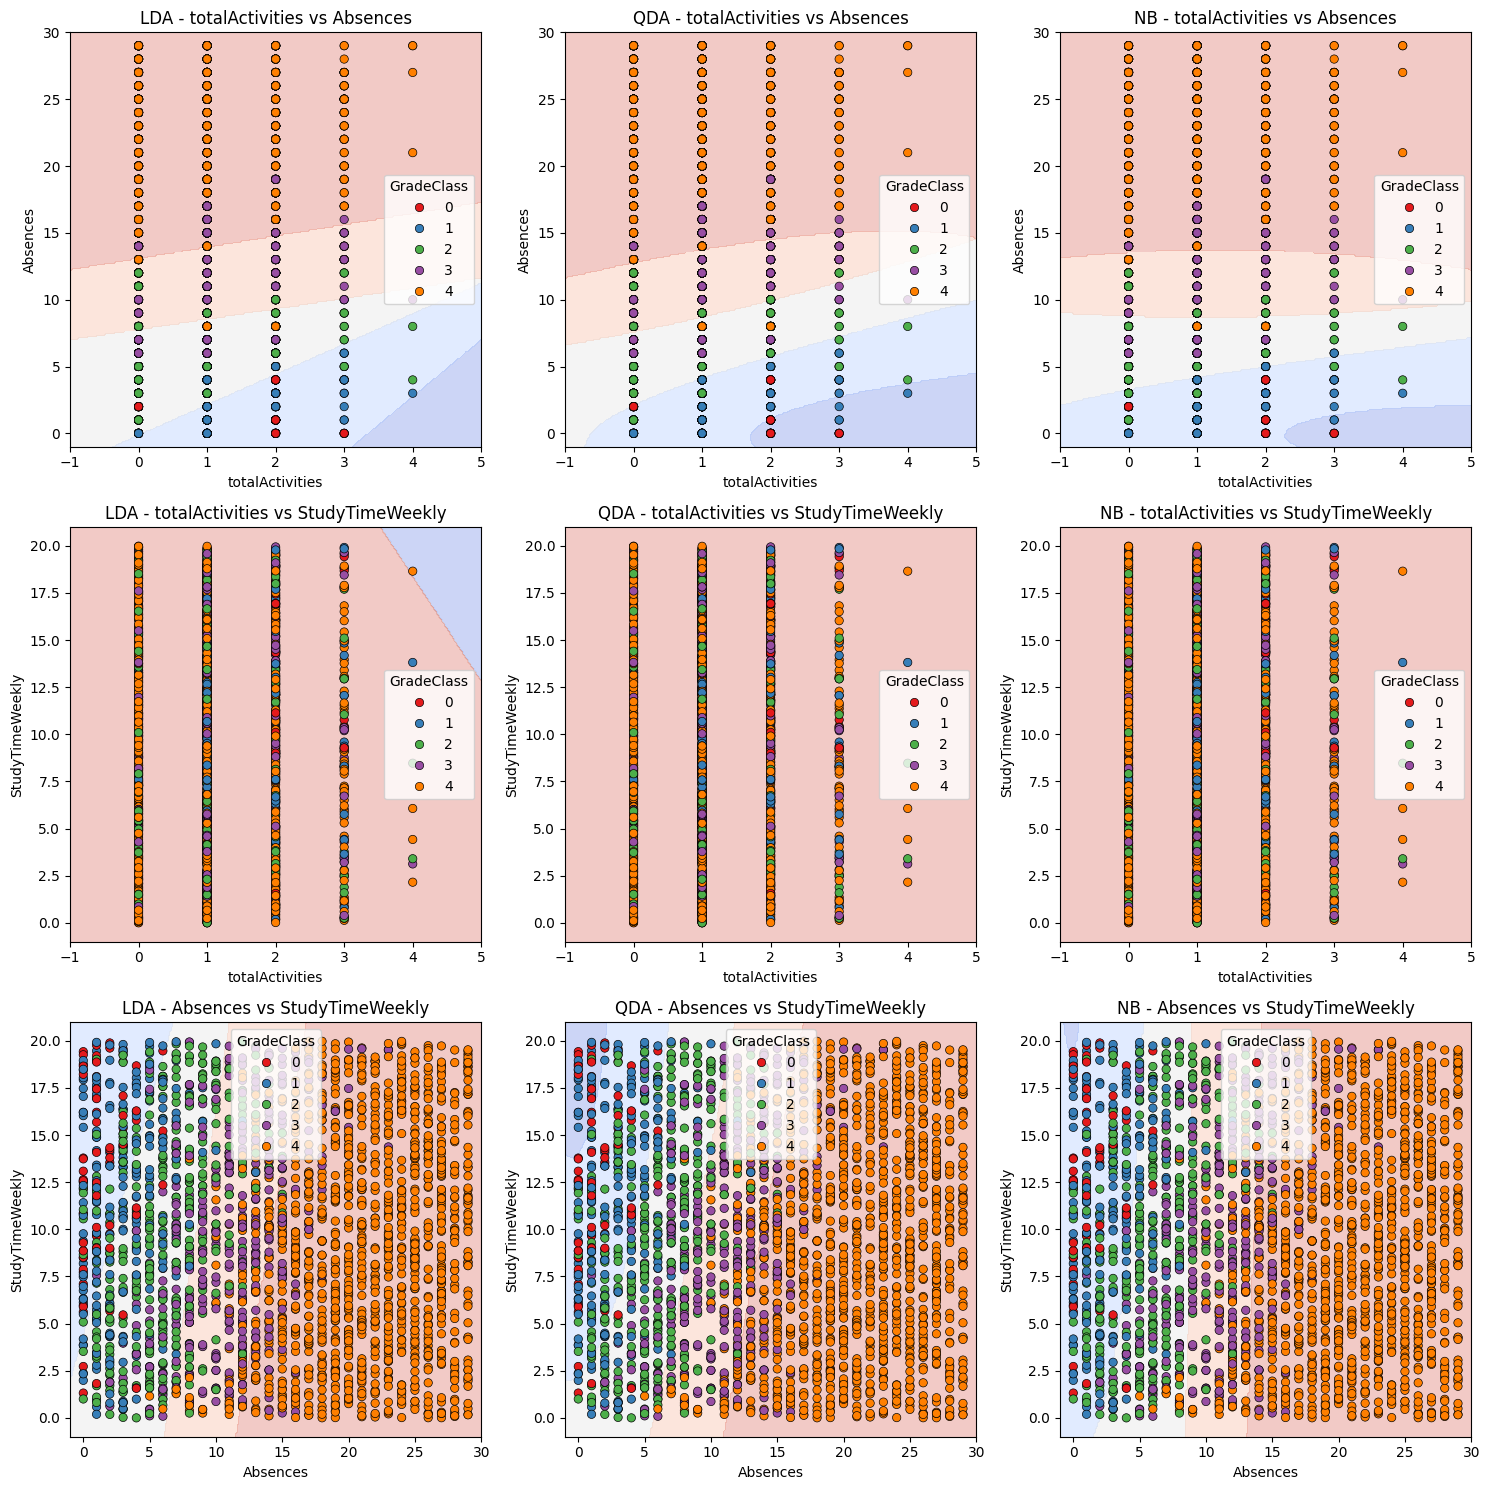

In [11]:
# Fonction pour tracer la frontière de décision sur 2D
def plot_decision_boundary(clf, X, y, ax, title):
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    clf.fit(X, y)
    if hasattr(clf, "predict_proba"):
        Z = clf.predict_proba(grid)[:, 1]  # prob classe 1 (si binaire)
    else:
        Z = clf.predict(grid)
    Z = clf.predict(grid)
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(len(np.unique(y))+1)-0.5, cmap='coolwarm')
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette="Set1", ax=ax, edgecolor='k')
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])
    ax.set_title(title)
    ax.legend(title="GradeClass")

# Variables à combiner
features = ['totalActivities', 'Absences', 'StudyTimeWeekly']

# On génère toutes les combinaisons possibles de 2 features
from itertools import combinations
pairs = list(combinations(features, 2))

models = [
    (LinearDiscriminantAnalysis(), "LDA"),
    (QuadraticDiscriminantAnalysis(), "QDA"),
    (GaussianNB(), "NB"),
]

# Dataframe simplifiée
df = data_new_grade_class[features + ['GradeClass']]
y = df['GradeClass']

# Plot
fig, axes = plt.subplots(len(pairs), len(models), figsize=(15, 5*len(pairs)))
if len(pairs) == 1:
    axes = axes.reshape(1, -1)  # Pour gérer le cas 1 ligne

for i, (feat1, feat2) in enumerate(pairs):
    X_pair = df[[feat1, feat2]]
    for j, (model, name) in enumerate(models):
        ax = axes[i, j]
        plot_decision_boundary(model, X_pair, y, ax, f"{name} - {feat1} vs {feat2}")

plt.tight_layout()
plt.show()


Partial conclusion: the TotalActivities variable does not seem to have a very significant impact on performance (confirmed: 1%).

c:\Users\romal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\romal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(
c:\Users\romal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


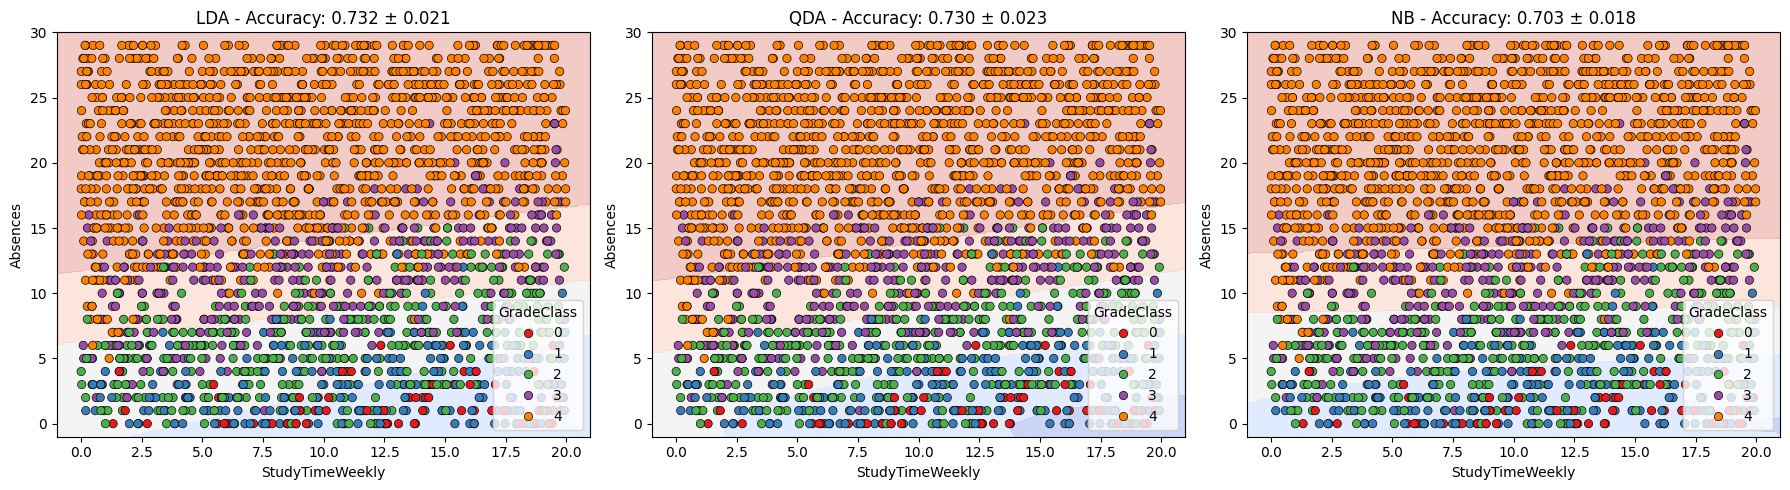

In [12]:
# Sélection des variables
features = ['StudyTimeWeekly', 'Absences']
df = data_new_grade_class[features + ['GradeClass']]
X = df[features]
y = df['GradeClass']

models = [
    (LinearDiscriminantAnalysis(), "LDA"),
    (QuadraticDiscriminantAnalysis(), "QDA"),
    (GaussianNB(), "NB"),
]

def plot_decision_boundary(clf, X, y, ax, title):
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    clf.fit(X, y)
    Z = clf.predict(grid)
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(len(np.unique(y))+1)-0.5, cmap='coolwarm')
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette="Set1", ax=ax, edgecolor='k')
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])
    ax.set_title(title)
    ax.legend(title="GradeClass")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (model, name) in zip(axes, models):
    # Calcul précision CV
    scores = cross_val_score(model, X, y, cv=10)
    mean_acc = scores.mean()
    std_acc = scores.std()
    title = f"{name} - Accuracy: {mean_acc:.3f} ± {std_acc:.3f}"
    
    plot_decision_boundary(model, X, y, ax, title)

plt.tight_layout()
plt.show()


B. With a focus on the variables : ParentalEducation, ParentalSupport, Tutoring

Partial conclusion: the variables ParentalEducation, ParentalSupport and Tutoring don't contribute to the performance (if we put all individuals in the same category, we get 53% accuracy).

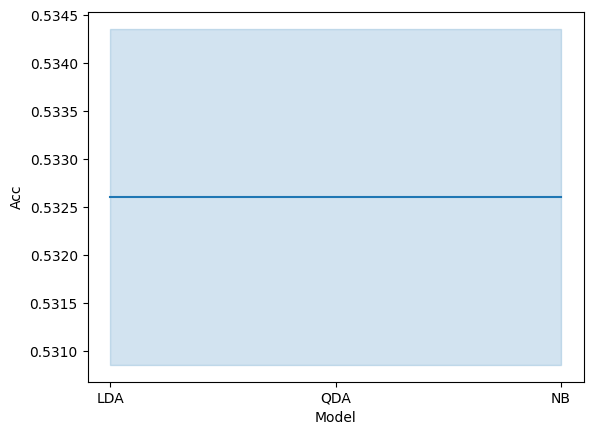

In [13]:
df = data_new_grade_class[['ParentalEducation', 'ParentalSupport', 'Tutoring', 'GradeClass']]

models = [
    (LinearDiscriminantAnalysis, "LDA"),
    (QuadraticDiscriminantAnalysis, "QDA"),
    (GaussianNB, "NB"),
]

def validation_accuracies(df, models):
    y = df['GradeClass']
    X = df.drop(columns=['GradeClass'])
    for model, name in models:
        scores = cross_val_score(model(), X, y, cv=10)
        for score in scores:
            yield name, score


df_scores = pd.DataFrame(validation_accuracies(df, models), columns=["Model", "Accuracy"])


df_val = pd.DataFrame(validation_errors_pca(df, models), columns=["Model", "Acc"])
sns.lineplot(x="Model", y="Acc", data=df_val, errorbar="sd")
plt.show()


4. Extensive selection of combinations of variables (9): Age, Gender, Ethnicity, ParentalEducation, StudyTimeWeekly, Absences, Tutoring, ParentalSupport, totalActivities

In [14]:
variables = [
    'Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 
    'Absences', 'Tutoring', 'ParentalSupport', 'totalActivities'
]

df = data_new_grade_class.copy()
y = df['GradeClass']

models = [
    (LinearDiscriminantAnalysis(), "LDA"),
    (QuadraticDiscriminantAnalysis(), "QDA"),
    (GaussianNB(), "NB"),
]

results = []

for r in range(2, len(variables)+1):
    combs = list(combinations(variables, r))
    print(f"Traitement des combinaisons de taille {r} ({len(combs)} combos)")
    
    for comb in tqdm.tqdm(combs):
        X = df[list(comb)]
        
        for model, name in models:
            try:
                scores = cross_val_score(model, X, y, cv=10)
                mean_acc = scores.mean()
            except Exception as e:
                mean_acc = None
                print(f"Erreur pour {name} avec {comb}: {e}")
            
            results.append({
                "Model": name,
                "Variables": comb,
                "NumVariables": len(comb),
                "Accuracy": mean_acc,
            })

results_df = pd.DataFrame(results)

# Affichatge top 10
print(results_df.sort_values(by="Accuracy", ascending=False).head(10))

Traitement des combinaisons de taille 2 (36 combos)


100%|██████████| 36/36 [00:05<00:00,  6.18it/s]


Traitement des combinaisons de taille 3 (84 combos)


100%|██████████| 84/84 [00:13<00:00,  6.42it/s]


Traitement des combinaisons de taille 4 (126 combos)


100%|██████████| 126/126 [00:21<00:00,  5.77it/s]


Traitement des combinaisons de taille 5 (126 combos)


100%|██████████| 126/126 [00:19<00:00,  6.31it/s]


Traitement des combinaisons de taille 6 (84 combos)


100%|██████████| 84/84 [00:13<00:00,  6.14it/s]


Traitement des combinaisons de taille 7 (36 combos)


100%|██████████| 36/36 [00:05<00:00,  6.24it/s]


Traitement des combinaisons de taille 8 (9 combos)


100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


Traitement des combinaisons de taille 9 (1 combos)


100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


     Model                                          Variables  NumVariables  \
1114   QDA  (StudyTimeWeekly, Absences, Tutoring, Parental...             5   
1447   QDA  (Age, Ethnicity, StudyTimeWeekly, Absences, Tu...             7   
1366   QDA  (ParentalEducation, StudyTimeWeekly, Absences,...             6   
1363   QDA  (Ethnicity, StudyTimeWeekly, Absences, Tutorin...             6   
1345   QDA  (Gender, StudyTimeWeekly, Absences, Tutoring, ...             6   
1468   QDA  (Gender, Ethnicity, StudyTimeWeekly, Absences,...             7   
1282   QDA  (Age, StudyTimeWeekly, Absences, Tutoring, Par...             6   
1471   QDA  (Gender, ParentalEducation, StudyTimeWeekly, A...             7   
1474   QDA  (Ethnicity, ParentalEducation, StudyTimeWeekly...             7   
1429   QDA  (Age, Gender, StudyTimeWeekly, Absences, Tutor...             7   

      Accuracy  
1114  0.816050  
1447  0.814787  
1366  0.813551  
1363  0.812692  
1345  0.811447  
1468  0.811437  
1282  0.811

C:\Users\romal\AppData\Local\Temp\ipykernel_5192\555312861.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=results_df, x='NumVariables', y='Accuracy', hue='Model', ci='sd')


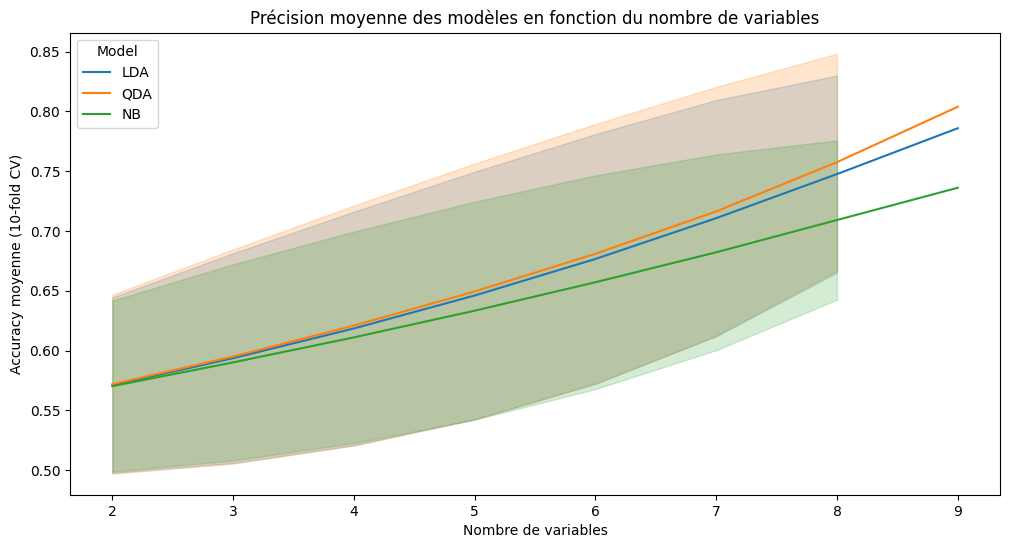

In [15]:
plt.figure(figsize=(12,6))
sns.lineplot(data=results_df, x='NumVariables', y='Accuracy', hue='Model', ci='sd')
plt.title("Précision moyenne des modèles en fonction du nombre de variables")
plt.xlabel("Nombre de variables")
plt.ylabel("Accuracy moyenne (10-fold CV)")
plt.show()

In [16]:
# Convertir les tuples de variables en chaîne de caractères pour plus de lisibilité
results_df['Variables_str'] = results_df['Variables'].apply(lambda x: ", ".join(x))

# Afficher le top 10 trié par précision décroissante
top10 = results_df.sort_values(by="Accuracy", ascending=False).head(10)

# Affichage clair des résultats
print(top10[['Model', 'Variables_str', 'NumVariables', 'Accuracy']])

     Model                                      Variables_str  NumVariables  \
1114   QDA  StudyTimeWeekly, Absences, Tutoring, ParentalS...             5   
1447   QDA  Age, Ethnicity, StudyTimeWeekly, Absences, Tut...             7   
1366   QDA  ParentalEducation, StudyTimeWeekly, Absences, ...             6   
1363   QDA  Ethnicity, StudyTimeWeekly, Absences, Tutoring...             6   
1345   QDA  Gender, StudyTimeWeekly, Absences, Tutoring, P...             6   
1468   QDA  Gender, Ethnicity, StudyTimeWeekly, Absences, ...             7   
1282   QDA  Age, StudyTimeWeekly, Absences, Tutoring, Pare...             6   
1471   QDA  Gender, ParentalEducation, StudyTimeWeekly, Ab...             7   
1474   QDA  Ethnicity, ParentalEducation, StudyTimeWeekly,...             7   
1429   QDA  Age, Gender, StudyTimeWeekly, Absences, Tutori...             7   

      Accuracy  
1114  0.816050  
1447  0.814787  
1366  0.813551  
1363  0.812692  
1345  0.811447  
1468  0.811437  
1282  0.811

In [17]:
# Trier par précision décroissante
results_df_sorted = results_df.sort_values(by="Accuracy", ascending=False)

# Convertir les tuples en chaîne lisible (si ce n'est pas déjà fait)
results_df_sorted['Variables_str'] = results_df_sorted['Variables'].apply(lambda x: ", ".join(x))

# Sauvegarder dans un CSV
results_df_sorted.to_csv('results_discriminant_analysis.csv', 
                         columns=['Model', 'Variables_str', 'NumVariables', 'Accuracy'],
                         index=False)

print("Fichier 'results_discriminant_analysis.csv' créé avec succès.")


Fichier 'results_discriminant_analysis.csv' créé avec succès.


In [18]:
# On commence par enlever les lignes où la précision est None (en cas d'erreur)
results_clean = results_df.dropna(subset=['Accuracy'])

# Pour chaque (Model, NumVariables), on garde la ligne avec la meilleure Accuracy
best_per_group = results_clean.loc[
    results_clean.groupby(['Model', 'NumVariables'])['Accuracy'].idxmax()
].copy()

# Convertir tuples en chaîne lisible
best_per_group['Variables_str'] = best_per_group['Variables'].apply(lambda x: ", ".join(x))

# Trier pour affichage propre
best_per_group = best_per_group.sort_values(['Model', 'NumVariables'])

# Sauvegarder dans un CSV
best_per_group.to_csv('best_solutions_per_model_numvariables.csv',
                      columns=['Model', 'NumVariables', 'Variables_str', 'Accuracy'],
                      index=False)

print("Fichier 'best_solutions_per_model_numvariables.csv' créé avec succès.")


Fichier 'best_solutions_per_model_numvariables.csv' créé avec succès.


A. With 2 classes to predict: Pass/Fail

In [19]:
variables = [
    'Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 
    'Absences', 'Tutoring', 'ParentalSupport', 'totalActivities'
]

df = data_new_grade_class.copy()


df['GradeBinary'] = df['GradeClass'].apply(lambda x: 1 if x == 4 else 0)  # 1 = F, 0 = non-F
y = df['GradeBinary']

models = [
    (LinearDiscriminantAnalysis(), "LDA"),
    (QuadraticDiscriminantAnalysis(), "QDA"),
    (GaussianNB(), "NB"),
]

results = []

for r in range(2, len(variables)+1):
    combs = list(combinations(variables, r))
    print(f"Traitement des combinaisons de taille {r} ({len(combs)} combos)")
    
    for comb in tqdm.tqdm(combs):
        X = df[list(comb)]
        
        for model, name in models:
            try:
                scores = cross_val_score(model, X, y, cv=10)
                mean_acc = scores.mean()
            except Exception as e:
                mean_acc = None
                print(f"Erreur pour {name} avec {comb}: {e}")
            
            results.append({
                "Model": name,
                "Variables": comb,
                "NumVariables": len(comb),
                "Accuracy": mean_acc,
            })

results_df = pd.DataFrame(results)

# Affichage du top 10
print(results_df.sort_values(by="Accuracy", ascending=False).head(10))

Traitement des combinaisons de taille 2 (36 combos)


100%|██████████| 36/36 [00:05<00:00,  6.80it/s]


Traitement des combinaisons de taille 3 (84 combos)


100%|██████████| 84/84 [00:12<00:00,  6.82it/s]


Traitement des combinaisons de taille 4 (126 combos)


100%|██████████| 126/126 [00:18<00:00,  6.90it/s]


Traitement des combinaisons de taille 5 (126 combos)


100%|██████████| 126/126 [00:20<00:00,  6.26it/s]


Traitement des combinaisons de taille 6 (84 combos)


100%|██████████| 84/84 [00:14<00:00,  5.75it/s]


Traitement des combinaisons de taille 7 (36 combos)


100%|██████████| 36/36 [00:05<00:00,  6.12it/s]


Traitement des combinaisons de taille 8 (9 combos)


100%|██████████| 9/9 [00:01<00:00,  6.46it/s]


Traitement des combinaisons de taille 9 (1 combos)


100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

     Model                                          Variables  NumVariables  \
1467   LDA  (Gender, Ethnicity, StudyTimeWeekly, Absences,...             7   
1113   LDA  (StudyTimeWeekly, Absences, Tutoring, Parental...             5   
1344   LDA  (Gender, StudyTimeWeekly, Absences, Tutoring, ...             6   
1470   LDA  (Gender, ParentalEducation, StudyTimeWeekly, A...             7   
1365   LDA  (ParentalEducation, StudyTimeWeekly, Absences,...             6   
1500   LDA  (Gender, Ethnicity, ParentalEducation, StudyTi...             8   
1366   QDA  (ParentalEducation, StudyTimeWeekly, Absences,...             6   
1428   LDA  (Age, Gender, StudyTimeWeekly, Absences, Tutor...             7   
1473   LDA  (Ethnicity, ParentalEducation, StudyTimeWeekly...             7   
1282   QDA  (Age, StudyTimeWeekly, Absences, Tutoring, Par...             6   

      Accuracy  
1467  0.939794  
1113  0.938961  
1344  0.938959  
1470  0.938959  
1365  0.938541  
1500  0.938539  
1366  0.938

In [20]:
# 1. Résultats triés par précision décroissante
results_sorted = results_df.sort_values(by="Accuracy", ascending=False)
results_sorted.to_csv("resultats_tous.csv", index=False)

# 2. Meilleurs résultats par modèle et nombre de variables
best_per_model_numvar = results_df.sort_values(by="Accuracy", ascending=False) \
    .groupby(["Model", "NumVariables"], as_index=False) \
    .first()

best_per_model_numvar.to_csv("meilleurs_resultats_par_modele.csv", index=False)

print("CSV créés :")
print("- resultats_tous.csv")
print("- meilleurs_resultats_par_modele.csv")


CSV créés :
- resultats_tous.csv
- meilleurs_resultats_par_modele.csv


B. With 3 classes to predict: Bad/In the middle/Good results

In [21]:
variables = [
    'Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 
    'Absences', 'Tutoring', 'ParentalSupport', 'totalActivities'
]

df = data_new_grade_class.copy()

df['Grade3Class'] = df['GradeClass'].apply(lambda x: 'F' if x == 4 else ('A' if x == 0 else 'Other'))
y = df['Grade3Class']

models = [
    (LinearDiscriminantAnalysis(), "LDA"),
    (QuadraticDiscriminantAnalysis(), "QDA"),
    (GaussianNB(), "NB"),
]

results = []

for r in range(2, len(variables)+1):
    combs = list(combinations(variables, r))
    print(f"Traitement des combinaisons de taille {r} ({len(combs)} combos)")
    
    for comb in tqdm.tqdm(combs):
        X = df[list(comb)]
        
        for model, name in models:
            try:
                scores = cross_val_score(model, X, y, cv=10)
                mean_acc = scores.mean()
            except Exception as e:
                mean_acc = None
                print(f"Erreur pour {name} avec {comb}: {e}")
            
            results.append({
                "Model": name,
                "Variables": comb,
                "NumVariables": len(comb),
                "Accuracy": mean_acc,
            })


results_df = pd.DataFrame(results)


results_sorted = results_df.sort_values(by="Accuracy", ascending=False)
results_sorted.to_csv("resultats_trois_classes_tous.csv", index=False)

best_per_model_numvar = results_df.sort_values(by="Accuracy", ascending=False) \
    .groupby(["Model", "NumVariables"], as_index=False).first()
best_per_model_numvar.to_csv("meilleurs_resultats_trois_classes.csv", index=False)

print("CSV créés :")
print("- resultats_trois_classes_tous.csv")
print("- meilleurs_resultats_trois_classes.csv")

Traitement des combinaisons de taille 2 (36 combos)


100%|██████████| 36/36 [00:07<00:00,  4.84it/s]


Traitement des combinaisons de taille 3 (84 combos)


100%|██████████| 84/84 [00:18<00:00,  4.44it/s]


Traitement des combinaisons de taille 4 (126 combos)


100%|██████████| 126/126 [00:27<00:00,  4.55it/s]


Traitement des combinaisons de taille 5 (126 combos)


100%|██████████| 126/126 [00:28<00:00,  4.43it/s]


Traitement des combinaisons de taille 6 (84 combos)


100%|██████████| 84/84 [00:19<00:00,  4.42it/s]


Traitement des combinaisons de taille 7 (36 combos)


100%|██████████| 36/36 [00:08<00:00,  4.18it/s]


Traitement des combinaisons de taille 8 (9 combos)


100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


Traitement des combinaisons de taille 9 (1 combos)


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

CSV créés :
- resultats_trois_classes_tous.csv
- meilleurs_resultats_trois_classes.csv


5. Evaluation with metrics adapted to the ordinal variable (5 classes)

In [ ]:
variables = [
    'Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 
    'Absences', 'Tutoring', 'ParentalSupport', 'totalActivities'
]

df = data_new_grade_class.copy()

df['Grade3Class'] = df['GradeClass'].apply(lambda x: 'F' if x == 4 else ('A' if x == 0 else 'Other'))
y = df['Grade3Class']

models = [
    (LinearDiscriminantAnalysis(), "LDA"),
    (QuadraticDiscriminantAnalysis(), "QDA"),
    (GaussianNB(), "NB"),
]

results = []

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for r in range(2, len(variables)+1):
    combs = list(combinations(variables, r))
    print(f"Traitement des combinaisons de taille {r} ({len(combs)} combos)")
    
    for comb in tqdm.tqdm(combs):
        X = df[list(comb)]
        
        for model, name in models:
            try:
                y_pred = cross_val_predict(model, X, y, cv=cv)
                acc = accuracy_score(y, y_pred)
                prec = precision_score(y, y_pred, average='macro', zero_division=0)
                rec = recall_score(y, y_pred, average='macro', zero_division=0)
                f1 = f1_score(y, y_pred, average='macro', zero_division=0)
            except Exception as e:
                acc = prec = rec = f1 = None
                print(f"Erreur pour {name} avec {comb}: {e}")
            
            results.append({
                "Model": name,
                "Variables": comb,
                "NumVariables": len(comb),
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1_Score": f1,
            })

results_df = pd.DataFrame(results)

# Sauvegarde
results_sorted = results_df.sort_values(by="F1_Score", ascending=False)  # tri sur F1 par exemple
results_sorted.to_csv("resultats_trois_classes_metrics.csv", index=False)

best_per_model_numvar = results_df.sort_values(by="F1_Score", ascending=False) \
    .groupby(["Model", "NumVariables"], as_index=False).first()
best_per_model_numvar.to_csv("meilleurs_resultats_trois_classes_metrics.csv", index=False)

print("CSV créés :")
print("- resultats_trois_classes_metrics.csv")
print("- meilleurs_resultats_trois_classes_metrics.csv")

Traitement des combinaisons de taille 2 (36 combos)


100%|██████████| 36/36 [00:09<00:00,  3.60it/s]


Traitement des combinaisons de taille 3 (84 combos)


 58%|█████▊    | 49/84 [00:14<00:11,  3.16it/s]

In [ ]:
variables = [
    'Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 
    'Absences', 'Tutoring', 'ParentalSupport', 'totalActivities'
]

df = data_new_grade_class.copy()

# Binarisation de la cible : 1 = F, 0 = non-F
df['GradeBinary'] = df['GradeClass'].apply(lambda x: 1 if x == 4 else 0)
y = df['GradeBinary']

models = [
    (LinearDiscriminantAnalysis(), "LDA"),
    (QuadraticDiscriminantAnalysis(), "QDA"),
    (GaussianNB(), "NB"),
]

results = []

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for r in range(2, len(variables)+1):
    combs = list(combinations(variables, r))
    print(f"Traitement des combinaisons de taille {r} ({len(combs)} combos)")
    
    for comb in tqdm.tqdm(combs):
        X = df[list(comb)]
        
        for model, name in models:
            try:
                y_pred = cross_val_predict(model, X, y, cv=cv)
                acc = accuracy_score(y, y_pred)
                prec = precision_score(y, y_pred, zero_division=0)
                rec = recall_score(y, y_pred, zero_division=0)
                f1 = f1_score(y, y_pred, zero_division=0)
            except Exception as e:
                acc = prec = rec = f1 = None
                print(f"Erreur pour {name} avec {comb}: {e}")
            
            results.append({
                "Model": name,
                "Variables": comb,
                "NumVariables": len(comb),
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1_Score": f1,
            })

results_df = pd.DataFrame(results)

# Sauvegarde des résultats triés par F1-score décroissant
results_sorted = results_df.sort_values(by="F1_Score", ascending=False)
results_sorted.to_csv("resultats_binaire_metrics.csv", index=False)

# Meilleurs résultats par modèle et nombre de variables
best_per_model_numvar = results_df.sort_values(by="F1_Score", ascending=False) \
    .groupby(["Model", "NumVariables"], as_index=False).first()
best_per_model_numvar.to_csv("meilleurs_resultats_binaire_metrics.csv", index=False)

print("CSV créés :")
print("- resultats_binaire_metrics.csv")
print("- meilleurs_resultats_binaire_metrics.csv")

Traitement des combinaisons de taille 2 (36 combos)


100%|██████████| 36/36 [00:05<00:00,  6.38it/s]


Traitement des combinaisons de taille 3 (84 combos)


100%|██████████| 84/84 [00:12<00:00,  6.77it/s]


Traitement des combinaisons de taille 4 (126 combos)


100%|██████████| 126/126 [00:18<00:00,  6.72it/s]


Traitement des combinaisons de taille 5 (126 combos)


100%|██████████| 126/126 [00:18<00:00,  6.67it/s]


Traitement des combinaisons de taille 6 (84 combos)


100%|██████████| 84/84 [00:12<00:00,  6.55it/s]


Traitement des combinaisons de taille 7 (36 combos)


100%|██████████| 36/36 [00:05<00:00,  6.63it/s]


Traitement des combinaisons de taille 8 (9 combos)


100%|██████████| 9/9 [00:01<00:00,  6.14it/s]


Traitement des combinaisons de taille 9 (1 combos)


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

CSV créés :
- resultats_binaire_metrics.csv
- meilleurs_resultats_binaire_metrics.csv


In [ ]:
variables = [
    'Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 
    'Absences', 'Tutoring', 'ParentalSupport', 'totalActivities'
]

df = data_new_grade_class.copy()
y = df['GradeClass']  # Grades 0-4 (A-F)

models = [
    (LinearDiscriminantAnalysis(), "LDA"),
    (QuadraticDiscriminantAnalysis(), "QDA"),
    (GaussianNB(), "NB"),
]

results = []

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for r in range(2, len(variables)+1):
    combs = list(combinations(variables, r))
    print(f"Traitement des combinaisons de taille {r} ({len(combs)} combos)")
    
    for comb in tqdm.tqdm(combs):
        X = df[list(comb)]
        
        for model, name in models:
            try:
                y_pred = cross_val_predict(model, X, y, cv=cv)
                acc = accuracy_score(y, y_pred)
                prec = precision_score(y, y_pred, average='macro', zero_division=0)
                rec = recall_score(y, y_pred, average='macro', zero_division=0)
                f1 = f1_score(y, y_pred, average='macro', zero_division=0)
            except Exception as e:
                acc = prec = rec = f1 = None
                print(f"Erreur pour {name} avec {comb}: {e}")
            
            results.append({
                "Model": name,
                "Variables": comb,
                "NumVariables": len(comb),
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1_Score": f1,
            })

results_df = pd.DataFrame(results)

# Tri par F1-score et export
results_sorted = results_df.sort_values(by="F1_Score", ascending=False)
results_sorted.to_csv("resultats_gradeclass_5classes_metrics.csv", index=False)

# Meilleur résultat par modèle et taille
best_per_model_numvar = results_sorted.groupby(["Model", "NumVariables"], as_index=False).first()
best_per_model_numvar.to_csv("meilleurs_resultats_gradeclass_5classes.csv", index=False)

# Affichage top 10
print(results_sorted.head(10))


Traitement des combinaisons de taille 2 (36 combos)


100%|██████████| 36/36 [00:05<00:00,  6.54it/s]


Traitement des combinaisons de taille 3 (84 combos)


100%|██████████| 84/84 [00:14<00:00,  5.97it/s]


Traitement des combinaisons de taille 4 (126 combos)


100%|██████████| 126/126 [00:21<00:00,  5.94it/s]


Traitement des combinaisons de taille 5 (126 combos)


100%|██████████| 126/126 [00:20<00:00,  6.22it/s]


Traitement des combinaisons de taille 6 (84 combos)


100%|██████████| 84/84 [00:13<00:00,  6.20it/s]


Traitement des combinaisons de taille 7 (36 combos)


100%|██████████| 36/36 [00:06<00:00,  5.98it/s]


Traitement des combinaisons de taille 8 (9 combos)


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


Traitement des combinaisons de taille 9 (1 combos)


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

     Model                                          Variables  NumVariables  \
1282   QDA  (Age, StudyTimeWeekly, Absences, Tutoring, Par...             6   
1114   QDA  (StudyTimeWeekly, Absences, Tutoring, Parental...             5   
1366   QDA  (ParentalEducation, StudyTimeWeekly, Absences,...             6   
1363   QDA  (Ethnicity, StudyTimeWeekly, Absences, Tutorin...             6   
1474   QDA  (Ethnicity, ParentalEducation, StudyTimeWeekly...             7   
1447   QDA  (Age, Ethnicity, StudyTimeWeekly, Absences, Tu...             7   
1501   QDA  (Gender, Ethnicity, ParentalEducation, StudyTi...             8   
1429   QDA  (Age, Gender, StudyTimeWeekly, Absences, Tutor...             7   
1471   QDA  (Gender, ParentalEducation, StudyTimeWeekly, A...             7   
1345   QDA  (Gender, StudyTimeWeekly, Absences, Tutoring, ...             6   

      Accuracy  Precision    Recall  F1_Score  
1282  0.817726   0.728179  0.712257  0.717592  
1114  0.817726   0.727878  0.71124

In [ ]:
variables = [
    'Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 
    'Absences', 'Tutoring', 'ParentalSupport', 'totalActivities'
]

df = data_new_grade_class.copy()
y = df['GradeClass']  # Grades 0-4 (A-F)

models = [
    (LinearDiscriminantAnalysis(), "LDA"),
    (QuadraticDiscriminantAnalysis(), "QDA"),
    (GaussianNB(), "NB"),
]

results = []

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for r in range(2, len(variables)+1):
    combs = list(combinations(variables, r))
    print(f"Traitement des combinaisons de taille {r} ({len(combs)} combos)")
    
    for comb in tqdm.tqdm(combs):
        X = df[list(comb)]
        
        for model, name in models:
            try:
                y_pred = cross_val_predict(model, X, y, cv=cv)
                acc = accuracy_score(y, y_pred)
                prec = precision_score(y, y_pred, average='macro', zero_division=0)
                rec = recall_score(y, y_pred, average='macro', zero_division=0)
                f1 = f1_score(y, y_pred, average='macro', zero_division=0)
                kappa = cohen_kappa_score(y, y_pred, weights='quadratic')
            except Exception as e:
                acc = prec = rec = f1 = kappa = None
                print(f"Erreur pour {name} avec {comb}: {e}")
            
            results.append({
                "Model": name,
                "Variables": comb,
                "NumVariables": len(comb),
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1_Score": f1,
                "Weighted_Kappa": kappa,
            })

results_df = pd.DataFrame(results)

# Tri par Weighted Kappa (de meilleur à moins bon)
results_sorted = results_df.sort_values(by="Weighted_Kappa", ascending=False)

# Export
results_sorted.to_csv("resultats_gradeclass_5classes_weighted_kappa.csv", index=False)

# Meilleur résultat par modèle et taille selon Weighted Kappa
best_per_model_numvar = results_sorted.groupby(["Model", "NumVariables"], as_index=False).first()
best_per_model_numvar.to_csv("meilleurs_resultats_gradeclass_5classes_weighted_kappa.csv", index=False)

# Affichage top 10 selon Weighted Kappa
print(results_sorted.head(10))


Traitement des combinaisons de taille 2 (36 combos)


100%|██████████| 36/36 [00:06<00:00,  5.96it/s]


Traitement des combinaisons de taille 3 (84 combos)


100%|██████████| 84/84 [00:14<00:00,  5.93it/s]


Traitement des combinaisons de taille 4 (126 combos)


100%|██████████| 126/126 [00:20<00:00,  6.10it/s]


Traitement des combinaisons de taille 5 (126 combos)


100%|██████████| 126/126 [00:20<00:00,  6.17it/s]


Traitement des combinaisons de taille 6 (84 combos)


100%|██████████| 84/84 [00:13<00:00,  6.02it/s]


Traitement des combinaisons de taille 7 (36 combos)


100%|██████████| 36/36 [00:05<00:00,  6.19it/s]


Traitement des combinaisons de taille 8 (9 combos)


100%|██████████| 9/9 [00:01<00:00,  6.05it/s]


Traitement des combinaisons de taille 9 (1 combos)


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


     Model                                          Variables  NumVariables  \
1114   QDA  (StudyTimeWeekly, Absences, Tutoring, Parental...             5   
1282   QDA  (Age, StudyTimeWeekly, Absences, Tutoring, Par...             6   
1363   QDA  (Ethnicity, StudyTimeWeekly, Absences, Tutorin...             6   
1447   QDA  (Age, Ethnicity, StudyTimeWeekly, Absences, Tu...             7   
1468   QDA  (Gender, Ethnicity, StudyTimeWeekly, Absences,...             7   
1474   QDA  (Ethnicity, ParentalEducation, StudyTimeWeekly...             7   
1366   QDA  (ParentalEducation, StudyTimeWeekly, Absences,...             6   
1345   QDA  (Gender, StudyTimeWeekly, Absences, Tutoring, ...             6   
1498   QDA  (Age, Ethnicity, ParentalEducation, StudyTimeW...             8   
1471   QDA  (Gender, ParentalEducation, StudyTimeWeekly, A...             7   

      Accuracy  Precision    Recall  F1_Score  Weighted_Kappa  
1114  0.817726   0.727878  0.711244  0.717007        0.931347  
12

In [ ]:
variables = [
    'Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'StudyTimeWeekly', 
    'Absences', 'Tutoring', 'ParentalSupport', 'totalActivities'
]

df = data_new_grade_class.copy()
y = df['GradeClass']  # Grades 0-4 (A-F)

models = [
    (LinearDiscriminantAnalysis(), "LDA"),
    (QuadraticDiscriminantAnalysis(), "QDA"),
    (GaussianNB(), "NB"),
]

results = []

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for r in range(2, len(variables)+1):
    combs = list(combinations(variables, r))
    print(f"Traitement des combinaisons de taille {r} ({len(combs)} combos)")
    
    for comb in tqdm.tqdm(combs):
        X = df[list(comb)]
        
        for model, name in models:
            try:
                y_pred = cross_val_predict(model, X, y, cv=cv)
                acc = accuracy_score(y, y_pred)
                prec = precision_score(y, y_pred, average='macro', zero_division=0)
                rec = recall_score(y, y_pred, average='macro', zero_division=0)
                f1 = f1_score(y, y_pred, average='macro', zero_division=0)
                kappa = cohen_kappa_score(y, y_pred, weights='quadratic')
                mae = mean_absolute_error(y, y_pred)
                rho, _ = spearmanr(y, y_pred)
            except Exception as e:
                acc = prec = rec = f1 = kappa = mae = rho = None
                print(f"Erreur pour {name} avec {comb}: {e}")
            
            results.append({
                "Model": name,
                "Variables": comb,
                "NumVariables": len(comb),
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1_Score": f1,
                "Weighted_Kappa": kappa,
                "MAE": mae,
                "SpearmanRho": rho,
            })

results_df = pd.DataFrame(results)

# Tri par Weighted Kappa
results_sorted = results_df.sort_values(by="Weighted_Kappa", ascending=False)

# Export complet
results_sorted.to_csv("resultats_gradeclass_5classes_full_metrics.csv", index=False)

# Meilleur résultat par modèle et taille selon Weighted Kappa
best_per_model_numvar = results_sorted.groupby(["Model", "NumVariables"], as_index=False).first()
best_per_model_numvar.to_csv("meilleurs_resultats_gradeclass_5classes_full_metrics.csv", index=False)

# Affichage top 10
print(results_sorted.head(10))

Traitement des combinaisons de taille 2 (36 combos)


  0%|          | 0/36 [00:00<?, ?it/s]C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
  3%|▎         | 1/36 [00:00<00:06,  5.76it/s]C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coeffi

Traitement des combinaisons de taille 3 (84 combos)


  0%|          | 0/84 [00:00<?, ?it/s]C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
  1%|          | 1/84 [00:00<00:13,  6.19it/s]C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coeffi

Traitement des combinaisons de taille 4 (126 combos)


  0%|          | 0/126 [00:00<?, ?it/s]C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
  1%|          | 1/126 [00:00<00:20,  6.25it/s]C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coef

Traitement des combinaisons de taille 5 (126 combos)


  0%|          | 0/126 [00:00<?, ?it/s]C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
  2%|▏         | 2/126 [00:00<00:21,  5.64it/s]C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
  2%|▏         | 3/126 [00:00<00:21,  5.72it/s]C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: A

Traitement des combinaisons de taille 6 (84 combos)


  1%|          | 1/84 [00:00<00:14,  5.62it/s]C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
  2%|▏         | 2/84 [00:00<00:14,  5.64it/s]C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(y, y_pred)
  4%|▎         | 3/84 [00:00<00:14,  5.61it/s]C:\Users\romal\AppData\Local\Temp\ipykernel_11552\2356217540.py:35: ConstantInputWarni

Traitement des combinaisons de taille 7 (36 combos)


100%|██████████| 36/36 [00:07<00:00,  5.04it/s]


Traitement des combinaisons de taille 8 (9 combos)


100%|██████████| 9/9 [00:01<00:00,  4.99it/s]


Traitement des combinaisons de taille 9 (1 combos)


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

     Model                                          Variables  NumVariables  \
1114   QDA  (StudyTimeWeekly, Absences, Tutoring, Parental...             5   
1282   QDA  (Age, StudyTimeWeekly, Absences, Tutoring, Par...             6   
1363   QDA  (Ethnicity, StudyTimeWeekly, Absences, Tutorin...             6   
1447   QDA  (Age, Ethnicity, StudyTimeWeekly, Absences, Tu...             7   
1468   QDA  (Gender, Ethnicity, StudyTimeWeekly, Absences,...             7   
1474   QDA  (Ethnicity, ParentalEducation, StudyTimeWeekly...             7   
1366   QDA  (ParentalEducation, StudyTimeWeekly, Absences,...             6   
1345   QDA  (Gender, StudyTimeWeekly, Absences, Tutoring, ...             6   
1498   QDA  (Age, Ethnicity, ParentalEducation, StudyTimeW...             8   
1471   QDA  (Gender, ParentalEducation, StudyTimeWeekly, A...             7   

      Accuracy  Precision    Recall  F1_Score  Weighted_Kappa       MAE  \
1114  0.817726   0.727878  0.711244  0.717007        0.